# Hierarchical Architecture

> Creating a custom architecture for hierarchical data to improve performance

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]

This post will cover an architecture modification for training models when there is a hierarchy with the data.  We will be exploring this in the pets dataset and we see significant improvement in accuracy using this architecture:

The general approach will be:
+ Train a model to predict pet breeds
+ Train a model to predict pet species
+ Cut off the heads of both models and feed both into a shared head to predict pet breeds.

We will be comparing this to a single model predicting pet breeds.  1 Epoch of a normal model is equivalent to 3 epochs in this new architecture and the comparisons we show represent it as such.  I'll cover why when we get there.

>Credit: [tyoc213](https://twitter.com/tyoc213) came up with this idea in discord as we were chatting.  It sounded interesting so I decided to try it out and it worked amazing!

Lets get started!

In [1]:
from fastai.vision.all import *

seed = 42

path = untar_data(URLs.PETS)
img = (path/'images').ls()[0]

# Get Dataloaders

We will start with creating a model for pet breeds and a model for pet species, so we will need dataloaders for each of those models.  I will not cover how this works, but if you would like more details I recommend looking at the fastai datablock tutorial on their documentation page.

We are going to be using **really small images (56x56)** to make this problem hard enough to experiment with.

In [2]:
#collapse-hide
def label_func(fname):
    return "cat" if str(fname.name[0]).isupper() else "dog"
def get_dls(get_y):
    pets = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_items = get_image_files,
        splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
        get_y= get_y,
        item_tfms=Resize(460),
        batch_tfms=aug_transforms(min_scale = 0.9,size=56)
    )
    return pets.dataloaders(path/"images",bs=64)

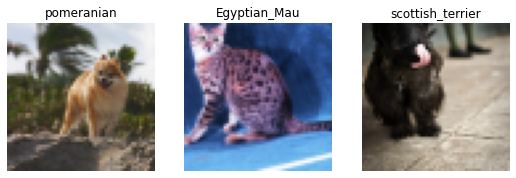

In [3]:
dls_breed = get_dls(using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'))
dls_breed.show_batch(max_n=3)

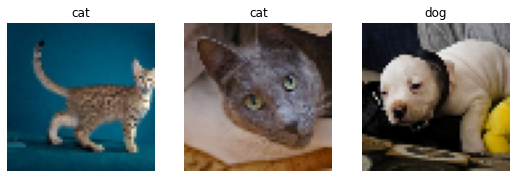

In [4]:
dls_species = get_dls(label_func)
dls_species.show_batch(max_n=3)

It's crucial that these dataloaders show the same images in their training and test sets.  If they don't, we would likely have a data leakage issue where each model has some of the others validation set in them.  This would be really problematic as we will be combining these models together at the end.

Lets add some quick tests to make sure that the valid imgs and the train images are the same.

In [41]:
breed_val = pd.DataFrame(dls_breed.valid.items,columns=['breed_imgs']).sort_values('breed_imgs')
species_val = pd.DataFrame(dls_species.valid.items,columns=['species_imgs']).sort_values('species_imgs')
assert (breed_val.breed_imgs==species_val.species_imgs).all()

In [43]:
breed_train = pd.DataFrame(dls_breed.train.items,columns=['breed_imgs']).sort_values('breed_imgs')
species_train = pd.DataFrame(dls_species.train.items,columns=['species_imgs']).sort_values('species_imgs')
assert (breed_train.breed_imgs==species_train.species_imgs).all()

# Create New Architecture

Now that we have our data let's break down the steps we need to do:

+ Train both individual models (1 for breed and 1 for species)
+ Create combiner architecture that takes both of those models and combines them to predict pet breed
+ Train final combined model

### Train Individual Models

So now, we put them into a learner and train each of the models for 10 epochs.  Nothing special yet.  I will be collapsing the outputs of the training cells - we will look at the results at the end.  But feel free to expand them out and look if you want.

Clearly these models will learn different things.  After all one is predicting 37 classes and one is predicting only 2.

In [5]:
learn_breed = cnn_learner(dls_breed,resnet18,metrics=accuracy)
learn_breed.fine_tune(9,reset_opt=True)

In [6]:
learn_species = cnn_learner(dls_species,resnet18,metrics=accuracy)
learn_species.fine_tune(9,reset_opt=True)

### Combiner Architecture

In this section there's a few things to do:

+ "Cut" each of the individual models above to eliminate the final layer group
+ Create a model head that takes the features from the (new) last layer of the cut models and combines them
+ Split the new model into layers so we can tell our model the appropriate layers to freeze for transfer learning.

>Note: If any of this doesn't make sense to you, I recommend reading [Chapter 15 of the Deep Learning with Fastai and Pytorch book](https://github.com/fastai/fastbook/blob/master/15_arch_details.ipynb).  That chapter has all the concepts needed to understand what's going on here.

In [7]:
class PetsModel(Module):
    def __init__(self, encoder_species,encoder_breed,head):
        self.body_species = encoder_species[:-1] # cut species model
        self.body_breed = encoder_breed[:-1] # cut species model
        self.head = head
    
    def forward(self, x):
        # concatenate the outputs of the cut species and cut breed models together
        ftrs = torch.cat([self.body_species(x), self.body_breed(x)], dim=1)
        
        # Feed the concatenaded outputs to the model head
        return self.head(ftrs)

Great!  So we now have the general architecture.  It cuts the models, each model predicts on the same image, it gets concatenated together and then passed through the model head.  Let's initialize out actual model!  We can see we need 3 things:

+ **encoder_species:** We can grab the model for our species model about by grabbing learn_species.model
+ **encoder_breed:** learn_breed.model gives us the model we trained above for breeds
+ **head:** We will use the create_head function in fastai to generate a default head.  The arguments are pretty straightforward
    + We need 512*4 input features - This is found by looking at the outputs of the cut encoders
    + For outputs we need 1 output per class we are trying to predict

In [8]:
m = PetsModel(learn_species.model,learn_breed.model,create_head(512*4,len(learn_breed.dls.vocab)))

Now we define the layer splits. For simplicity let's have 3 layers.  1 for each of the base models, and 1 for the head.

In [9]:
def layer_splitter(model):
    return [params(model.body_species), params(model.body_breed), params(model.head)]

Now we can pass all this to a Learner and fine tune the last layer. `freeze` freezes the last model group, which we defined above as the model head.  This is perfect, because the other models have already been trained.

In [10]:
learn = Learner(dls_breed,m,metrics=accuracy,splitter=layer_splitter,loss_fun=CrossEntropyLossFlat())
learn.freeze()
learn.fit_one_cycle(1,reset_opt=True)

Finally, we unfreeze all the parameters and train the whole model for 10 epochs.

In [11]:
learn.unfreeze()
learn.fit_one_cycle(9)

# Baseline

We need to compare this to something so we know if it is actually helpful.  We will train 30 epochs so it's comparable.  After this, we will be ready to compare results!

>Note: The more complex model trained for about 30 epochs which is why we are doing that here.  10 epochs went to the species model, 10 epochs on the breed model, then 10 epochs for the final model.

In [14]:
learn_breed_only = cnn_learner(dls_breed,resnet18,metrics=accuracy,loss_fun=CrossEntropyLossFlat())
learn_breed_only.fine_tune(29,reset_opt=True)

# Results

Now, we graph the values from our models.  We can get all the values we need in a dataframe using the learn.recorder object so that we can plot them easy.  The code isn't all that interesting, but feel free to look if you would like.

The really interesting thing is the graph.  We see great trends all around:
+ Training loss decreasing
+ Validation loss decreases faster and more than baseline
+ Accuracy is **7 percentage points higher than baseline**

>Note: The combined model architecture line looks choppier than it is, because there's 1/3 the points.  If you remember 1 epoch of the combined model is roughly equivalent to 3 epochs of the baseline model.

In [15]:
#collapse-hide
df = pd.DataFrame(learn.recorder.values) # get results for new architecture
df.columns = learn.recorder.metric_names[1:-1]
df = pd.concat([df,df,df]) # duplicate 3x so that each epoch graphs as 3 epochs
df.sort_index(inplace=True)
df.reset_index(inplace=True,drop=True)

df_b = pd.DataFrame(learn_breed_only.recorder.values) # get results for baseline model
df_b.columns = learn_breed_only.recorder.metric_names[1:-1]

Text(0, 0.5, 'Accuracy')

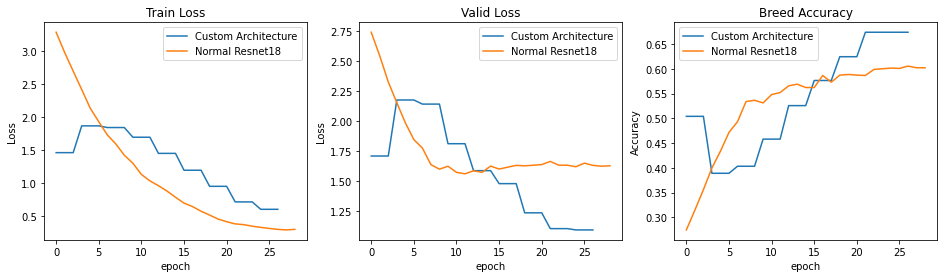

In [18]:
#collapse-hide
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3,figsize=(16,4))
for i in range(0,len(ax)):
    col = df.columns[i]
    ax[i].plot(df[col], label="Custom Architecture")    
    col_b = df_b.columns[i]
    ax[i].plot(df_b[col_b], label="Normal Resnet18")
    ax[i].legend()
    ax[i].set_xlabel('epoch')
ax[0].set_title('Train Loss'); ax[1].set_title('Valid Loss'); ax[2].set_title('Breed Accuracy')
ax[0].set_ylabel('Loss');ax[1].set_ylabel('Loss');ax[2].set_ylabel('Accuracy')
